<h1 align="center">OpenSAFELY Service Restoration Observatory Monthly Dashboard: Eleven key measures for monitoring general practice clinical activity during COVID-19 </h1>

**This notebook accompanies [this report](https://reports.opensafely.org/reports/sro-measures/), describing trends and variation in clinical activity codes using a set of key measures indicative of overall activity to evaluate NHS service restoration throughout the COVID-19 pandemic. This version includes data from the EHR provider TPP only and will be updated regularly. For a more detailed analysis please see the report linked above and the accompanying [preprint](https://www.medrxiv.org/content/10.1101/2022.10.17.22281058v1.article-info).**

The aim of the OpenSAFELY SRO is to describe trends and variation in clinical activity codes to evaluate NHS service restoration during the COVID-19 pandemic.

This report provides a set of key measures of general practice activity, that are indicative of changes in overall activity throughout the COVID-19 pandemic. These key measures were selected from a range of clinical areas, prioritising clinical topics that would benefit from routine monitoring and targeted action considering the following criteria: high volume usage, clinically relevant to front-line practice and whether they are more widely indicative of other problems in service delivery across the NHS (for example a decrease in records for blood tests for kidney function may be a true drop in GPs requesting these tests or it may be related to delays in laboratories processing the results).

For each of these measures we provide a link to the codelist containing all the codes used for that measure, a description of what the measure is and a brief overview of why the measure is important. We also highlight any caveats, where there are any, for each measure. For each measure we also indicate the number of unique patients recorded as having at least one event indicated by the measure as well as the total number of events since January 2019 and the number of events recorded in the latest month.

Monthly rates of recorded activity are displayed as practice level decile charts to show both the general trend and practice level variation in activity changes. Accompanying each chart is a summary of the most commonly recorded SNOMED-CT codes for each measure.

<h3 class="details">Summary of results</h3>

These key measures demonstrated substantial changes in clinical activity throughout the COVID-19 pandemic. Six of the measures recovered to their pre-pandemic baseline within a year of the pandemic, showing a rapid, adaptive response by primary care in the midst of a global health pandemic. The remaining five measures showed a more sustained drop in activity; asthma and COPD reviews did not recover to their pre-pandemic baseline until around August 2021 and blood pressure monitoring, cardiovascular disease risk assessment and medication reviews had a sustained drop in activity that persisted up to December 2021.

<h3 class="details">Findings in context</h3>

Discussion of the specific causes and reasons for the changes in narrow measures of clinical activity we have described is best addressed through quantitative analyses that identify practices in high and low deciles to approach for targeted qualitative interviews with patients and front line staff. However we believe the following broad points may help aid interpretation. Our measures reflect only a few areas of high volume clinical activity; decreases may reflect appropriate prioritisation of other clinical activity. For example NHS Health Checks, which are used to detect early signs of high blood pressure, heart disease or type 2 diabetes, were paused during the pandemic; this is likely to explain the sustained drop in activity in cardiovascular disease risk assessment and blood pressure monitoring. However, in specific cases this may reflect changes in the style of delivery of a clinical activity, rather than the volume: for example, where patients record their own blood pressure at home since, as we have previously highlighted, home monitoring of blood pressure may not be recorded completely or consistently in GP records. In addition, not all reductions should be interpreted as problematic: as part of the COVID-19 recovery, health systems are aiming to be more resilient, responsive and sustainable; complete recovery may not always be appropriate and reductions in clinical activity across some domains may reflect rational reprioritisation of activity. Where these changes in priority have not been nationally planned, data analyses such as ours may help to rapidly identify the pragmatic changes in prioritisation being made by individual dispersed organisations or people across the healthcare ecosystem before those changes are explicitly surfaced or discussed through other mechanisms. For more detail, please see our preprint [here](https://www.medrxiv.org/content/10.1101/2022.10.17.22281058v1.article-info).

The following key measures are provided:

<ul id="docNav">

<li> <a href="#systolic_bp">Blood Pressure Monitoring</a>
<li> <a href="#qrisk2">Cardiovascular Disease 10 Year Risk Assessment</a>
<li> <a href="#cholesterol">Cholesterol Testing</a>
<li> <a href="#ALT">Liver Function Testing - Alanine Transferaminase (ALT)</a>
<li> <a href="#serum_tsh">Thyroid Testing</a>
<li> <a href="#rbc_fbc">Full Blood Count - Red Blood Cell (RBC) Testing</a>
<li> <a href="#hba1c">Glycated Haemoglobin A1c Level (HbA1c)</a>
<li> <a href="#serum_sodium">Renal Function Assessment - Sodium Testing</a>
<li> <a href="#asthma">Asthma Reviews</a>
<li> <a href="#copd">Chronic Obstrutive Pulmonary Disease (COPD) Reviews</a>
<li> <a href="#med_review">Medication Review</a>

</ul>

In [37]:
import pandas as pd
from utilities import *
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
%config InlineBackend.figure_format='png'

In [38]:
%%capture --no-display

sentinel_measures = ["qrisk2", "asthma", "copd", "sodium", "cholesterol", "alt", "tsh", "rbc", 'hba1c', 'systolic_bp', 'medication_review']


In [39]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

def replace_with_correct_deciles(series):
    series = pd.Series([10, 20, 30, 40, 50, 60, 70, 80, 90, 1, 2, 3, 4, 5, 6, 7, 8, 9, 91, 92, 93, 94, 95, 96, 97, 98, 99])
    return series

def deciles_chart_ebm(
    df,
    period_column=None,
    column=None,
    title="",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=True,
    ax=None,
):
    """period_column must be dates / datetimes"""
    sns.set_style("whitegrid", {"grid.color": ".9"})
    if not ax:
        fig, ax = plt.subplots(1, 1)
    
    linestyles = {
        "decile": {
            "line": "b--",
            "linewidth": 1,
            "label": "decile",
        },
        "median": {
            "line": "b-",
            "linewidth": 1.5,
            "label": "median",
        },
        "percentile": {
            "line": "b:",
            "linewidth": 0.8,
            "label": "1st-9th, 91st-99th percentile",
        },
    }
    label_seen = []
    for percentile in range(1, 100):  # plot each decile line
        data = df[df["percentile"] == percentile]
        add_label = False

        if percentile == 50:
            style = linestyles["median"]
            add_label = True
        elif show_outer_percentiles and (percentile < 10 or percentile > 90):
            style = linestyles["percentile"]
            if "percentile" not in label_seen:
                label_seen.append("percentile")
                add_label = True
        else:
            style = linestyles["decile"]
            if "decile" not in label_seen:
                label_seen.append("decile")
                add_label = True
        if add_label:
            label = style["label"]
        else:
            label = "_nolegend_"

        ax.plot(
            data[period_column],
            data[column],
            style["line"],
            linewidth=style["linewidth"],
            label=label,
        )
    ax.set_ylabel(ylabel, size=15, alpha=0.6)
    if title:
        ax.set_title(title, size=18)
    # set ymax across all subplots as largest value across dataset
    ax.set_ylim([0, df[column].max() * 1.05])
    ax.tick_params(labelsize=12)
    ax.set_xlim(
        [df[period_column].min(), df[period_column].max()]
    )  # set x axis range as full date range

    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%B %Y"))
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=1))
    if show_legend:
        ax.legend(
            bbox_to_anchor=(1.05, 0.6),
            ncol=1,
            fontsize=12,
            borderaxespad=0.0,
            frameon=True,
        )

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    plt.gcf().autofmt_xdate(rotation=90, ha="center", which="both")

    return plt

for m in sentinel_measures:
    # Load deciles and generate deciles chart
    deciles = pd.read_csv(f"../backend_outputs/tpp/{m}/deciles_table_counts_per_week_per_practice.csv", parse_dates=['date'])

    # fix deciles
    deciles.loc[:, "percentile"] = deciles.groupby(by=["date"])[["percentile"]].transform(replace_with_correct_deciles)
    
    deciles.loc[:, "value"] = deciles.loc[:, "value"]*1000
    px = 1 / plt.rcParams["figure.dpi"]  # pixel in inches
    fig, ax = plt.subplots(
        1, 1, figsize=(800 * px, 400 * px), tight_layout=True
    )

    # remove last month - its incomplete
    deciles = deciles[deciles["date"] < "2022-10-01"]

    plot = deciles_chart_ebm(
        deciles,
        period_column="date",
        column="value",
        ylabel="rate per 1000",
        show_outer_percentiles=True,
        ax=ax,
    )
    plt.savefig(f"../backend_outputs/tpp/{m}/deciles_chart_counts_per_week_per_practice.png")
    plt.close()
    

In [40]:
%%capture
# non-displayed initial run due to gridlines bug
generate_sentinel_measure('systolic_bp', 'backend_outputs/tpp')

<a id="systolic_bp"></a>
## Blood Pressure Monitoring

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/systolic-blood-pressure-qof/3572b5fb/">this codelist</a>.

<h3 class="details">What is it and why does it matter?</h3>

A commonly-used assessment used to identify patients with hypertension or to ensure optimal treatment for those with known hypertension.  This helps ensure appropriate treatment, with the aim of reducing long term risks of complications from hypertension such as stroke, myocardial infarction and kidney disease. 

<h3 class="details">Caveats</h3>

We use codes which represent results reported to GPs so tests requested but not yet reported are not included. Only test results returned to GPs are included, which will usually exclude tests requested while a person is in hospital and other settings like a private clinic.

### Rate per 1000 registered patients

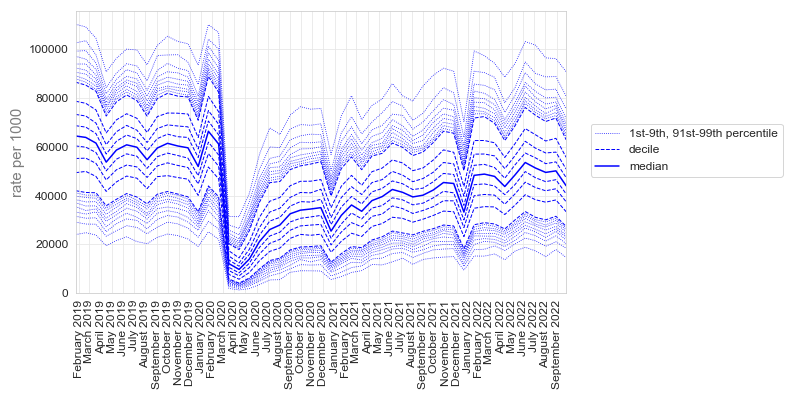

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/systolic-blood-pressure-qof/3572b5fb/>(Codelist)</a>

Code,Description,Proportion of codes (%)
72313002,Systolic arterial pressure,93.43
413606001,Average home systolic blood pressure,4.03
407554009,Sitting systolic blood pressure,0.76
400974009,Standing systolic blood pressure,0.66
314446007,Average day interval systolic blood pressure,0.27


Total patients: 13.96M (55.16M events)

Events in latest month: 1.12M

In [41]:
generate_sentinel_measure('systolic_bp', 'backend_outputs/tpp')

<a id="qrisk2"></a>
## Cardiovascular Disease 10 year Risk Assessment

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/cvd-risk-assessment-score-qof/1adf44a5/">this codelist</a>.

<h3 class="details">What is it and why does it matter? </h3>

A commonly-used risk assessment used to identify patients with an increased risk of cardiovascular events in the next 10 years. This helps ensure appropriate treatment, with the aim of reducing long term risks of complications such as stroke or myocardial infarction. 

### Rate per 1000 registered patients

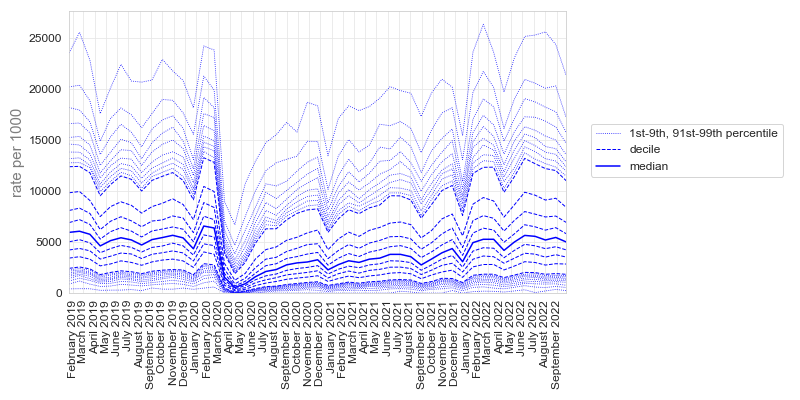

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/cvd-risk-assessment-score-qof/1adf44a5/>(Codelist)</a>

Code,Description,Proportion of codes (%)
718087004,QRISK2 cardiovascular disease 10 year risk score,98.64
763244005,QRISK cardiovascular disease 10 year risk calculator score,0.96
1085871000000105,QRISK3 cardiovascular disease 10 year risk calculator score,0.35
809311000000105,Joint British Societies cardiovascular disease risk score,0.02
752451000000100,Cardiovascular disease risk assessment by third party,0.02


Total patients: 3.72M (5.92M events)

Events in latest month: 0.14M

In [42]:
generate_sentinel_measure('qrisk2', 'backend_outputs/tpp')

<a id="cholesterol"></a>
## Cholesterol Testing

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/cholesterol-tests/09896c09/">Codelist</a>.

<h3 class="details">What is it and why does it matter?</h3>

A commonly-used blood test used as part of a routine cardiovascular disease 10 year risk assessment and also to identify patients with lipid disorders (e.g. familial hypercholesterolaemia). This helps ensure appropriate treatment, with the aim of reducing long term risks of complications such as stroke or myocardial infarction.

<h3 class="details">Caveats</h3>

We use codes which represent results reported to GPs so tests requested but not yet reported are not included. Only test results returned to GPs are included, which will usually exclude tests requested while a person is in hospital and other settings like a private clinic.

### Rate per 1000 registered patients

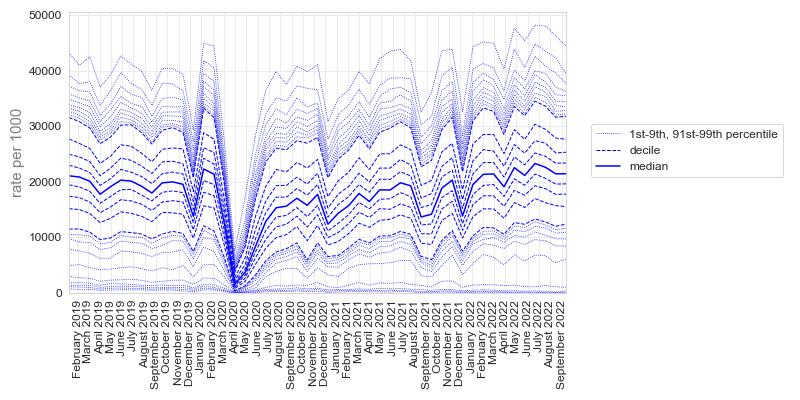

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/cholesterol-tests/09896c09/>(Codelist)</a>

Code,Description,Proportion of codes (%)
1005671000000105,Serum cholesterol level,98.99
1017161000000104,Plasma total cholesterol level,0.76
850981000000101,Cholesterol level,0.24
395153009,Pre-treatment serum cholesterol level,< 0.005


Total patients: 8.83M (21.13M events)

Events in latest month: 0.15M

In [43]:
generate_sentinel_measure('cholesterol', 'backend_outputs/tpp')

<a id="ALT"></a>
## Liver Function Testing - Alanine Transferaminase (ALT)

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/alanine-aminotransferase-alt-tests/2298df3e/">this codelist</a>.

<h3 class="details">What is it and why does it matter?</h3>

An ALT blood test is one of a group of liver function tests (LFTs) which are used to detect problems with the function of the liver.  It is often used to monitor patients on medications which may affect the liver or which rely on the liver to break them down within the body. They are also tested for patients with known or suspected liver dysfunction.  

<h3 class="details">Caveats</h3>

**In a small number of places, an ALT test may NOT be included within a liver function test**. We use codes which represent results reported to GPs so tests requested but not yet reported are not included. Only test results returned to GPs are included, which will usually exclude tests requested while a person is in hospital and other settings like a private clinic.

### Rate per 1000 registered patients

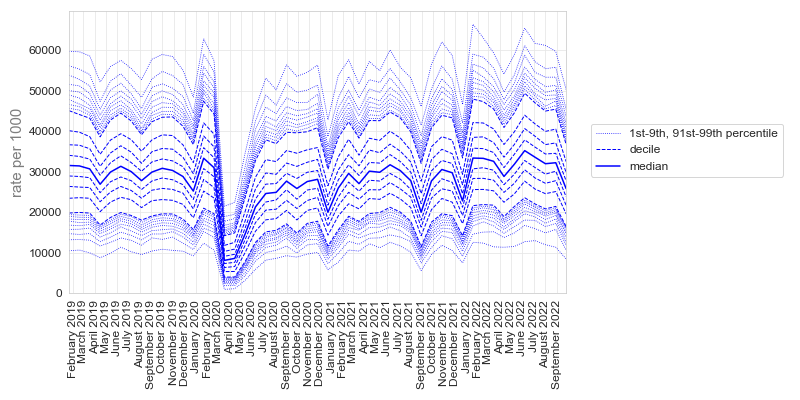

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/alanine-aminotransferase-alt-tests/2298df3e/>(Codelist)</a>

Code,Description,Proportion of codes (%)
1018251000000107,Serum alanine aminotransferase level,96.51
1013211000000103,Plasma alanine aminotransferase level,3.37
250637003,Alanine aminotransferase - blood measurement,0.06
34608000,Alanine aminotransferase measurement,0.06


Total patients: 12.20M (34.46M events)

Events in latest month: 0.65M

In [44]:
generate_sentinel_measure('alt', 'backend_outputs/tpp')

<a id="serum_tsh"></a>
## Thyroid Testing

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/thyroid-stimulating-hormone-tsh-testing/11a1abeb/">this codelist</a>.

<h3 class="details">What is it and why does it matter?</h3>

TSH is used for the diagnosis and monitoring of hypothyroidism and hyperthyroidism, including making changes to thyroid replacement therapy dosing.

<h3 class="details">Caveats</h3>

We use codes which represent results reported to GPs so tests requested but not yet reported are not included. Only test results returned to GPs are included, which will usually exclude tests requested while a person is in hospital and other settings like a private clinic.

### Rate per 1000 registered patients

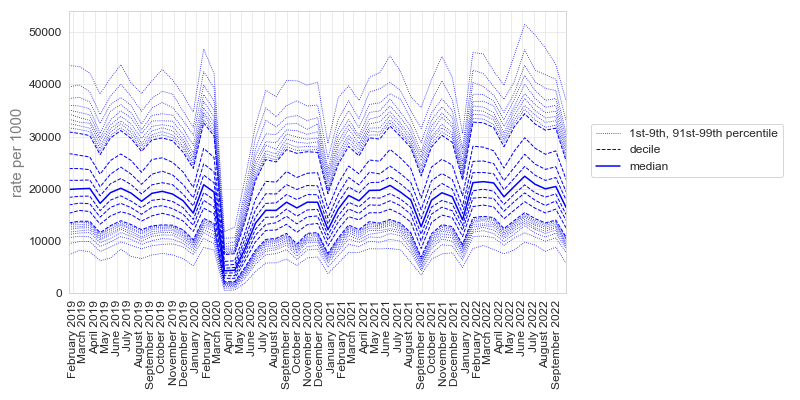

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/thyroid-stimulating-hormone-tsh-testing/11a1abeb/>(Codelist)</a>

Code,Description,Proportion of codes (%)
1022791000000101,Serum thyroid stimulating hormone level,97.55
1022801000000102,Plasma thyroid stimulating hormone level,2.25
1027151000000105,Thyroid stimulating hormone level,0.20


Total patients: 10.32M (22.32M events)

Events in latest month: 0.42M

In [45]:
generate_sentinel_measure('tsh', 'backend_outputs/tpp')

<a id="rbc_fbc"></a>
## Full Blood Count - Red Blood Cell (RBC) Testing

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/red-blood-cell-rbc-tests/576a859e/">this codelist</a>.

<h3 class="details">What is it and why does it matter?</h3>

RBC is completed as part of a group of tests referred to as a full blood count (FBC), used to detect a variety of disorders of the blood, such as anaemia and infection.

<h3 class="details">Caveats</h3>

We use codes which represent results reported to GPs so tests requested but not yet reported are not included. Only test results returned to GPs are included, which will usually exclude tests requested while a person is in hospital and other settings like a private clinic.

### Rate per 1000 registered patients

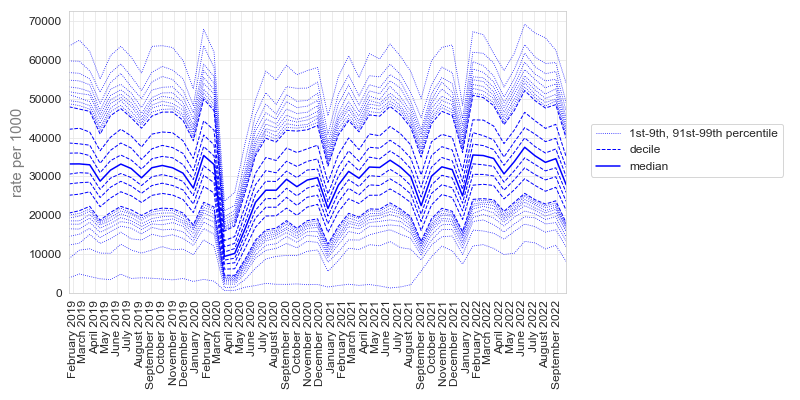

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/red-blood-cell-rbc-tests/576a859e/>(Codelist)</a>

Code,Description,Proportion of codes (%)
1022451000000103,Red blood cell count,100.0


Total patients: 12.61M (36.86M events)

Events in latest month: 0.70M

In [46]:
generate_sentinel_measure('rbc', 'backend_outputs/tpp')

<a id="hba1c"></a>
## Glycated Haemoglobin A1c Level (HbA1c)

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/glycated-haemoglobin-hba1c-tests/62358576/">this codelist</a>.

<h3 class="details">What is it and why does it matter?</h3>

HbA1c is a long term indicator of diabetes control. NICE guidelines recommend that individuals with diabetes have their HbA1c measured at least twice a year. Poor diabetic control can place individuals living with diabetes at an increased risk of the complications of diabetes.

<h3 class="details">Caveats</h3>

We use codes which represent results reported to GPs so tests requested but not yet reported are not included. Only test results returned to GPs are included, which will usually exclude tests requested while a person is in hospital and other settings like a private clinic.

### Rate per 1000 registered patients

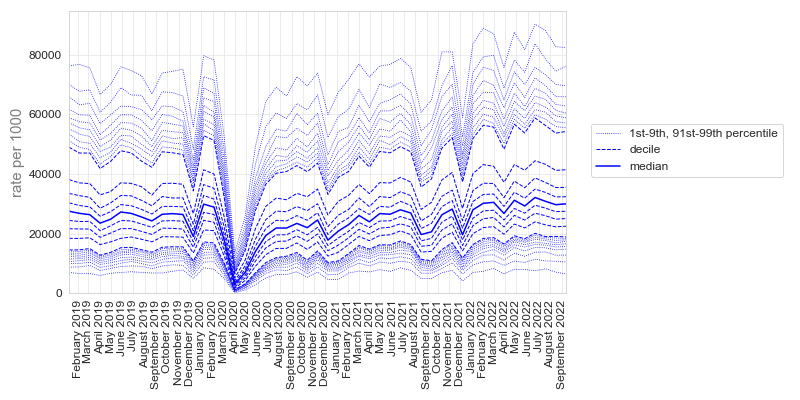

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/glycated-haemoglobin-hba1c-tests/62358576/>(Codelist)</a>

Code,Description,Proportion of codes (%)
999791000000106,Haemoglobin A1c level - International Federation of Clinical Chemistry and Laboratory Medicine standardised,84.65
1003671000000109,Haemoglobin A1c level,15.14
43396009,Hemoglobin A1c measurement,0.20
365845005,Hemoglobin A1C - diabetic control finding,0.01


Total patients: 10.83M (32.71M events)

Events in latest month: 0.22M

In [47]:
generate_sentinel_measure('hba1c', 'backend_outputs/tpp')


<a id="serum_sodium"></a>
## Renal Function Assessment - Sodium Testing

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/sodium-tests-numerical-value/32bff605/">this codelist</a>.

<h3 class="details">What is it and why does it matter?</h3>

Sodium is completed as part of a group of tests referred to as a renal profile, used to detect a variety of disorders of the kidneys. A renal profile is also often used to monitor patients on medications which may affect the kidneys or which rely on the kidneys to remove them from the body.

<h3 class="details">Caveats</h3>

We use codes which represent results reported to GPs so tests requested but not yet reported are not included. Only test results returned to GPs are included, which will usually exclude tests requested while a person is in hospital and other settings like a private clinic.

### Rate per 1000 registered patients

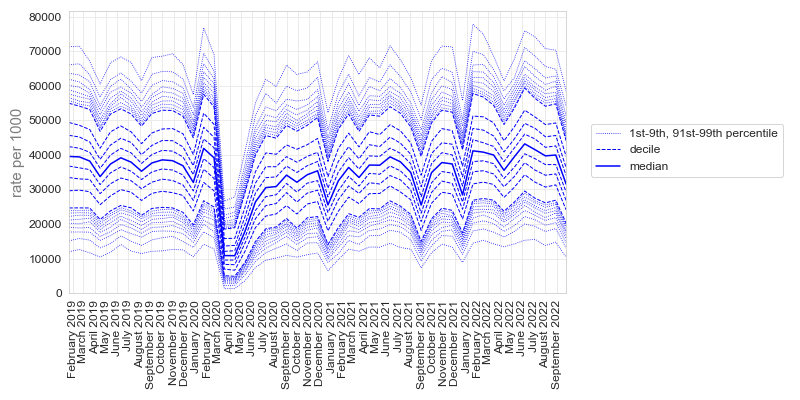

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/sodium-tests-numerical-value/32bff605/>(Codelist)</a>

Code,Description,Proportion of codes (%)
1000661000000107,Serum sodium level,97.82
1017381000000106,Plasma sodium level,2.18


Total patients: 12.87M (42.95M events)

Events in latest month: 0.80M

In [48]:
generate_sentinel_measure('sodium', 'backend_outputs/tpp')

<a id="asthma"></a>
## Asthma Reviews

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/asthma-annual-review-qof/33eeb7da/">this codelist</a>.  QoF recommends a number of codes that can be used by practices as an asthma annual review.  These are all included in our codelist.

<h3 class="details">What is it and why does it matter?</h3>

The British Thoracic Society and Scottish Intercollegiate Guidelines Network on the management of asthma recommend that people with asthma receive a review of their condition at least annually.If a patient has not been reviewed, it is possible that their asthma control may have worsened, leading to a greater chance of symptoms and admission to hospital.

### Rate per 1000 registered patients

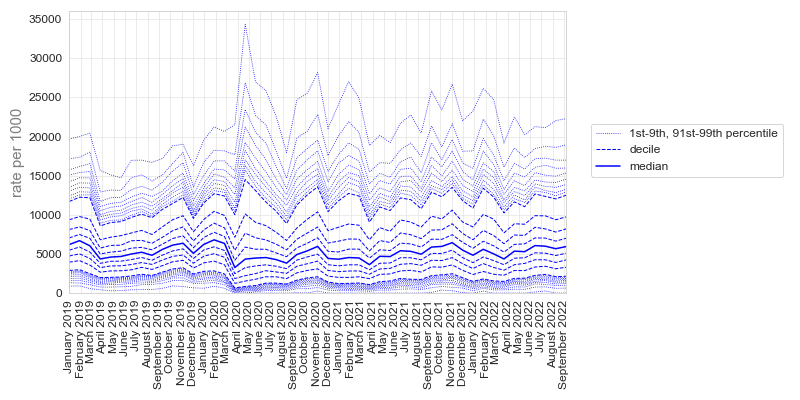

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/asthma-annual-review-qof/33eeb7da/>(Codelist)</a>

Code,Description,Proportion of codes (%)
394700004,Asthma annual review,60.80
394720003,Asthma medication review,16.37
401182001,Asthma monitoring by nurse,12.26
394701000,Asthma follow-up,5.01
390877003,Step up change in asthma management plan,2.51


Total patients: 1.89M (7.56M events)

Events in latest month: 0.11M

In [49]:
generate_sentinel_measure('asthma', 'backend_outputs/tpp')


<a id="copd"></a>
## Chronic Obstructive Pulmonary Disease (COPD) Reviews

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/chronic-obstructive-pulmonary-disease-copd-review-qof/01cfd170/">this codelist</a>.  

<h3 class="details">What is it and why does it matter?</h3>

It is recommended by NICE that all individuals living with COPD have an annual review with the exception of individuals living with very severe (stage 4) COPD being reviewed at least twice a year.
If a patient has not been reviewed, it is possible that their COPD control may have worsened, leading to a greater chance of symptoms and admission to hospital.


### Rate per 1000 registered patients

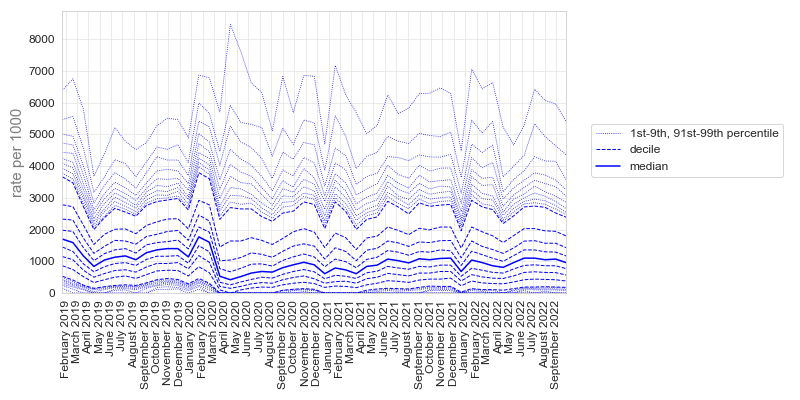

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/chronic-obstructive-pulmonary-disease-copd-review-qof/01cfd170/>(Codelist)</a>

Code,Description,Proportion of codes (%)
394703002,Chronic obstructive pulmonary disease annual review,93.67
760621000000103,Chronic obstructive pulmonary disease 6 monthly review,3.47
760601000000107,Chronic obstructive pulmonary disease 3 monthly review,2.85


Total patients: 0.56M (1.54M events)

Events in latest month: 0.03M

In [50]:
generate_sentinel_measure('copd', 'backend_outputs/tpp')

<a id="med_review"></a>
## Medication Reviews

The codes used in for this measure are a combination of codes available in <a href="https://www.opencodelists.org/codelist/opensafely/care-planning-medication-review-simple-reference-set-nhs-digital/61b13c39/">this NHS Digitatil medication planning refset</a> and <a href="https://www.opencodelists.org/codelist/nhsd-primary-care-domain-refsets/medrvw_cod/20200812/">this primary care domain medication review refset</a>.
 
<h3 class="details">What is it and why does it matter?</h3>

Many medicines are used long-term and they should be reviewed regularly to ensure they are still safe, effective and appropriate.
Medication review is a broad term ranging from a notes-led review without a patient, to an in-depth Structured Medication Review with multiple appointments and follow-up. The codelist provided captures all types of reviews to give an overview of medication reviews in primary care.

### Rate per 1000 registered patients

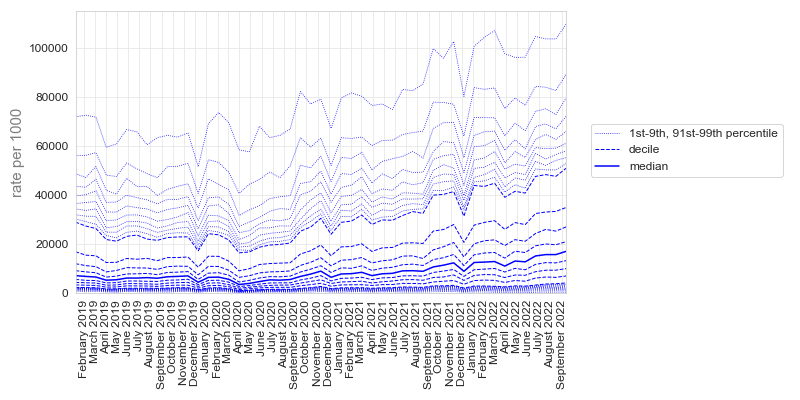

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/care-planning-medication-review-simple-reference-set-nhs-digital/61b13c39/>(Codelist 1)</a>, <a href=https://www.opencodelists.org/codelist/nhsd-primary-care-domain-refsets/medrvw_cod/20200812/>(Codelist 2)</a>

Code,Description,Proportion of codes (%)
182836005,Review of medication (procedure),14.14
88551000000109,Medication review with patient (procedure),12.86
185381007,Repeat medication check (procedure),8.93
1239511000000100,Structured medication review (procedure),8.43
93311000000106,Medication review of medical notes (procedure),7.52


Total patients: 5.84M (16.70M events)

Events in latest month: 0.22M

In [51]:
generate_sentinel_measure('medication_review', 'backend_outputs/tpp')